In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wot
import pandas as pd
import os
import ot
import time
import random
import anndata
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

In [2]:
rng = np.random.default_rng(0)
random.seed(0)

In [3]:
performance = {}
for net in ["VSC", "mCAD"]:
    traj = np.load(f"data/{net}_traj_combinded.npy")
    selected_time_points = [0, 50, 100, 400, 600, 650, 1000]
    traj = traj[:,:,selected_time_points]
    n_traj, n_dim, n_time = traj.shape

    adata = anndata.AnnData(X=np.vstack([traj[:,:,i] for i in range(n_time)]), obs=pd.DataFrame(np.repeat(selected_time_points, traj.shape[0]), columns=['time']))
    adata.obs["traj_id"] = np.concatenate([np.arange(n_traj) for i in range(n_time)])

    # Train test split
    permuted_idx = rng.permutation(np.arange(n_traj))
    idx_table = np.arange(adata.shape[0]).reshape(n_time,n_traj)

    train_idx = idx_table[:,permuted_idx[:int(n_traj * 0.6)]].flatten()
    valid_idx = idx_table[:,permuted_idx[int(n_traj * 0.6):int(n_traj * 0.6)+int(n_traj * 0.2)]].flatten()
    test_idx = idx_table[:,permuted_idx[int(n_traj * 0.6)+int(n_traj * 0.2):]].flatten()

    adata_train = adata[train_idx,:]
    adata_valid = adata[valid_idx,:]
    adata_test = adata[test_idx,:]
    adata_train.write_h5ad(f"data/{net}_7t_train.h5ad")
    adata_test.write_h5ad(f"data/{net}_7t_test.h5ad")
    pd.DataFrame(adata_train.X).to_csv(f"data/{net}_7t.train.csv", index=False)
    pd.DataFrame(adata_test.X).to_csv(f"data/{net}_7t.test.csv", index=False)

    traj_train = traj[permuted_idx[:int(n_traj * 0.6)],:,:]
    traj_valid = traj[permuted_idx[int(n_traj * 0.6):int(n_traj * 0.6)+int(n_traj * 0.2)],:,:]
    traj_test = traj[permuted_idx[int(n_traj * 0.6)+int(n_traj * 0.2):],:,:]
    
    # Test
    timepoints = adata_test.obs["time"].value_counts()
    timepoints.index = timepoints.index.get_level_values(0)

    def sampling_path(transition_matrixes, num_trajectory=None):
        assert len(transition_matrixes) == len(timepoints)-1
        t0_cell_num = transition_matrixes[0].shape[0]
        if num_trajectory is None:
            num_trajectory = t0_cell_num
        out = np.zeros((num_trajectory, len(timepoints)), dtype=int)
        out[:num_trajectory//t0_cell_num * t0_cell_num, 0] = np.repeat(np.arange(t0_cell_num), num_trajectory//t0_cell_num)
        out[num_trajectory//t0_cell_num * t0_cell_num:, 0] = np.arange(num_trajectory%t0_cell_num)
        index_offset = 0
        for i in range(len(timepoints)-1):
            start_idx = out[:,i] - index_offset
            index_offset += timepoints.values[i]
            # end_idx = (transition_matrixes[i][start_idx,:] * np.random.random((num_trajectory, transition_matrixes[i].shape[1]))).argmax(axis=1)
            end_idx = transition_matrixes[i][start_idx,:].argmax(axis=1)
            out[:,i+1] = end_idx + index_offset
        return(out)
    
    # WOT
    def job_test(i):
        ot_model = wot.ot.OTModel(adata_test,
                            epsilon=0.003,
                            lambda1=20,
                            lambda2=1,
                            growth_iters=3,
                            day_field="time",
                            # tolerance=1e-6,
                            # max_iter=1e5,
                            solver="fixed_iters",
                            )
        return(ot_model.compute_transport_map(timepoints.index[i], timepoints.index[i+1]).X)
    
    with Pool(len(timepoints)-1) as p:
        transition_matrixes_wot = p.map(job_test, range(len(timepoints)-1))
    traj_index_wot = sampling_path(transition_matrixes_wot)
    traj_test_reconstructed_wot = np.take(adata_test.X, traj_index_wot, axis=0).transpose(0,2,1)

    out_wot = []
    for i in range(len(timepoints)-1):
        real = np.take(traj_test[:,:,i+1], (traj_index_wot%traj_index_wot.shape[0])[:,i], axis=0)
        pred = traj_test_reconstructed_wot[:,:,i+1]
        dist = np.linalg.norm(real-pred, axis=1)
        out_wot.append((dist.mean(), dist.std()))
    
    # POT
    transition_matrixes_ot = [
                            ot.unbalanced.sinkhorn_unbalanced(
                                a = np.ones(timepoints.values[i]),
                                b = np.ones(timepoints.values[i+1]),
                                M = ot.dist(adata_test[adata_test.obs['time'] == timepoints.index[i],:].X, adata_test[adata_test.obs['time'] == timepoints.index[i+1],:].X),
                                # reg = 0.002,
                                # reg_m = (np.inf, 1e0),
                                # reg_m = 50,
                                reg=100.0,
                                reg_m=0.01,
                                reg_type="entropy",
                            ) for i in range(len(timepoints)-1)
                        ]
    traj_index_ot = sampling_path(transition_matrixes_ot)
    traj_test_reconstructed_ot = np.take(adata_test.X, traj_index_ot, axis=0).transpose(0,2,1)

    out_ot = []
    for i in range(len(timepoints)-1):
        real = np.take(traj_test[:,:,i+1], (traj_index_ot%traj_index_ot.shape[0])[:,i], axis=0)
        pred = traj_test_reconstructed_ot[:,:,i+1]
        dist = np.linalg.norm(real-pred, axis=1)
        out_ot.append((dist.mean(), dist.std()))

    # Random
    def sampling_path_randomly(transition_matrixes, num_trajectory=None):
        assert len(transition_matrixes) == len(timepoints)-1
        t0_cell_num = transition_matrixes[0].shape[0]
        if num_trajectory is None:
            num_trajectory = t0_cell_num
        out = np.zeros((num_trajectory, len(timepoints)), dtype=int)
        out[:num_trajectory//t0_cell_num * t0_cell_num, 0] = np.repeat(np.arange(t0_cell_num), num_trajectory//t0_cell_num)
        out[num_trajectory//t0_cell_num * t0_cell_num:, 0] = np.arange(num_trajectory%t0_cell_num)
        index_offset = 0
        for i in range(len(timepoints)-1):
            start_idx = out[:,i] - index_offset
            index_offset += timepoints.values[i]
            end_idx = np.random.randint(0, transition_matrixes[i].shape[1], num_trajectory)
            out[:,i+1] = end_idx + index_offset
        return(out)
    
    traj_index_rand = sampling_path_randomly(transition_matrixes_ot)
    traj_rand = np.take(adata_test.X, traj_index_rand, axis=0).transpose(0,2,1)

    out_rand = []
    for i in range(len(timepoints)-1):
        real = np.take(traj_test[:,:,i+1], (traj_index_rand%traj_index_rand.shape[0])[:,i], axis=0)
        pred = traj_rand[:,:,i+1]
        dist = np.linalg.norm(real-pred, axis=1)
        out_rand.append((dist.mean(), dist.std()))
    
    performance[net] = {
        "wot": out_wot,
        "ot": out_ot,
        "rand": out_rand,
    }

    # Train
    timepoints = adata_train.obs["time"].value_counts()
    timepoints.index = timepoints.index.get_level_values(0)

    # WOT
    def job(i):
        ot_model = wot.ot.OTModel(adata_train,
                            epsilon=0.003,
                            lambda1=20,
                            lambda2=1,
                            growth_iters=3,
                            day_field="time",
                            # tolerance=1e-6,
                            # max_iter=1e5,
                            solver="fixed_iters",
                            )
        return(ot_model.compute_transport_map(timepoints.index[i], timepoints.index[i+1]).X)
    
    with Pool(len(timepoints)-1) as p:
        transition_matrixes_wot = p.map(job, range(len(timepoints)-1))
    traj_index_wot = sampling_path(transition_matrixes_wot)
    traj_train_reconstructed_wot = np.take(adata_train.X, traj_index_wot, axis=0).transpose(0,2,1)

    out_wot = []
    for i in range(len(timepoints)-1):
        real = np.take(traj_train[:,:,i+1], (traj_index_wot%traj_index_wot.shape[0])[:,i], axis=0)
        pred = traj_train_reconstructed_wot[:,:,i+1]
        dist = np.linalg.norm(real-pred, axis=1)
        out_wot.append((dist.mean(), dist.std()))
    traj_train_reconstructed_wot = traj_train_reconstructed_wot.toarray()

    np.save(f"data/{net}_traj_reconstructed_7t_train.npy", traj_train_reconstructed_wot.transpose(0,2,1))
    np.save(f"data/{net}_traj_reconstructed_7t_test.npy", traj_test_reconstructed_wot.transpose(0,2,1))

local_pca set to 30, above gene count of 8. Disabling PCA
local_pca set to 30, above gene count of 8. Disabling PCA
local_pca set to 30, above gene count of 8. Disabling PCA
local_pca set to 30, above gene count of 8. Disabling PCA
local_pca set to 30, above gene count of 8. Disabling PCA
local_pca set to 30, above gene count of 8. Disabling PCA
local_pca set to 30, above gene count of 8. Disabling PCA
local_pca set to 30, above gene count of 8. Disabling PCA
local_pca set to 30, above gene count of 8. Disabling PCA
local_pca set to 30, above gene count of 8. Disabling PCA
local_pca set to 30, above gene count of 8. Disabling PCA
local_pca set to 30, above gene count of 8. Disabling PCA
local_pca set to 30, above gene count of 19. Disabling PCA
local_pca set to 30, above gene count of 19. Disabling PCA
local_pca set to 30, above gene count of 19. Disabling PCA
local_pca set to 30, above gene count of 19. Disabling PCA
local_pca set to 30, above gene count of 19. Disabling PCA
local_pca

In [9]:
performance

{'VSC': {'wot': [(1.9395058106460676, 0.6044640897054477),
   (1.358168230025985, 0.6053557417795493),
   (1.1217461494182894, 0.9575483890063475),
   (0.7398868954251224, 0.32697635113803186),
   (0.7626757942431811, 0.3154800666914643),
   (0.7876898644719963, 0.3473481491650386)],
  'ot': [(1.702338844327815, 0.43140315592381434),
   (1.8866934636967734, 0.24841802428517654),
   (2.453114828330097, 0.2792295313613995),
   (0.8062969758899103, 0.10405505491594735),
   (0.7573758375336482, 0.11629189910908677),
   (0.5118762504062155, 0.10531684128781882)],
  'rand': [(1.9669321738389132, 0.6375522563318018),
   (2.4219279036448724, 0.9779414228506327),
   (2.6824976005548886, 1.3687527301559037),
   (2.7029296265164113, 1.3589237504506175),
   (2.662782039398141, 1.372637266324872),
   (2.6529691929472916, 1.3772009772590879)]},
 'GSD': {'wot': [(1.3193690566555691, 0.34694624126420504),
   (1.787408276856483, 0.45918190992710595),
   (3.905281772102696, 2.1187312009624533),
   (1.52

In [5]:
performance = {'VSC': {'wot': [(1.9395058106460676, 0.6044640897054477),
   (1.358168230025985, 0.6053557417795493),
   (1.1217461494182894, 0.9575483890063475),
   (0.7398868954251224, 0.32697635113803186),
   (0.7626757942431811, 0.3154800666914643),
   (0.7876898644719963, 0.3473481491650386)],
  'ot': [(1.702338844327815, 0.43140315592381434),
   (1.8866934636967734, 0.24841802428517654),
   (2.453114828330097, 0.2792295313613995),
   (0.8062969758899103, 0.10405505491594735),
   (0.7573758375336482, 0.11629189910908677),
   (0.5118762504062155, 0.10531684128781882)],
  'rand': [(1.9669321738389132, 0.6375522563318018),
   (2.4219279036448724, 0.9779414228506327),
   (2.6824976005548886, 1.3687527301559037),
   (2.7029296265164113, 1.3589237504506175),
   (2.662782039398141, 1.372637266324872),
   (2.6529691929472916, 1.3772009772590879)]},
 'GSD': {'wot': [(1.3193690566555691, 0.34694624126420504),
   (1.787408276856483, 0.45918190992710595),
   (3.905281772102696, 2.1187312009624533),
   (1.5266276794933953, 0.817696243559652),
   (1.4458132007831632, 0.4487085624129196),
   (1.3458954875537108, 0.40328096376296707)],
  'ot': [(1.3719411946610782, 0.315501811650624),
   (1.8688435954687532, 2.220446049250313e-16),
   (5.2723277364742795, 8.881784197001252e-16),
   (6.022634756641737, 2.6645352591003757e-15),
   (3.0576633588204087, 0.0),
   (2.019814586882863, 4.440892098500626e-16)],
  'rand': [(1.0953158029452903, 0.32047406093729475),
   (1.7519256250147024, 0.4790558280566377),
   (4.111611202431198, 2.21082527637641),
   (4.261591893625411, 3.083555269585296),
   (4.375719710176722, 3.1320646907220064),
   (4.195108693327418, 3.1124484856512837)]},
 'HSC': {'wot': [(1.9819592864150837, 0.8152443108937474),
   (1.327430539885433, 0.6289025118589727),
   (1.5467943022403743, 1.3805309308092526),
   (0.8481473059939588, 0.3554584377503062),
   (0.8809186593329643, 0.3698371816804058),
   (0.9379246226897238, 0.44481030849733694)],
  'ot': [(1.9860681394717108, 0.5852287178353442),
   (2.7197311756095024, 0.07205402428355352),
   (4.301663565651159, 0.5589561265553544),
   (0.7935413893856035, 0.1823068894187298),
   (1.166868183429689, 0.0376492293052978),
   (1.3573771285096483, 0.022644709176425613)],
  'rand': [(2.113385139501087, 0.9127472033779555),
   (2.716548692443003, 1.2758489274506328),
   (3.4343508406001746, 1.911201091636413),
   (3.302757312024475, 1.9634434698576662),
   (3.357494824689765, 1.9613504128327035),
   (3.3642479428503878, 1.954229157237002)]},
 'mCAD': {'wot': [(0.8004420374234922, 0.46762637613653446),
   (1.0528631355664806, 0.695223809252658),
   (1.2035536935406959, 1.2226799713753402),
   (0.9060313258458281, 0.6231150710109117),
   (0.7793204460635442, 0.3846954629542403),
   (0.8512498437499052, 0.5288447973144009)],
  'ot': [(0.7623446970695312, 0.23051579134378816),
   (1.900354773337894, 0.021830119923853964),
   (3.5913902632319488, 0.468023449824901),
   (1.066072532859937, 0.044370828222092255),
   (0.5757507362563276, 0.03678965043620893),
   (1.5296694020305, 0.031205085879826438)],
  'rand': [(0.5141642717441255, 0.35892431746869013),
   (1.6991437798935793, 0.9669969124393183),
   (1.9891021178773085, 1.861045526893684),
   (1.8784250506508406, 1.8408552234859559),
   (1.8367466658221328, 1.8338159454827356),
   (1.902858631915215, 1.8412981318362616)]}}

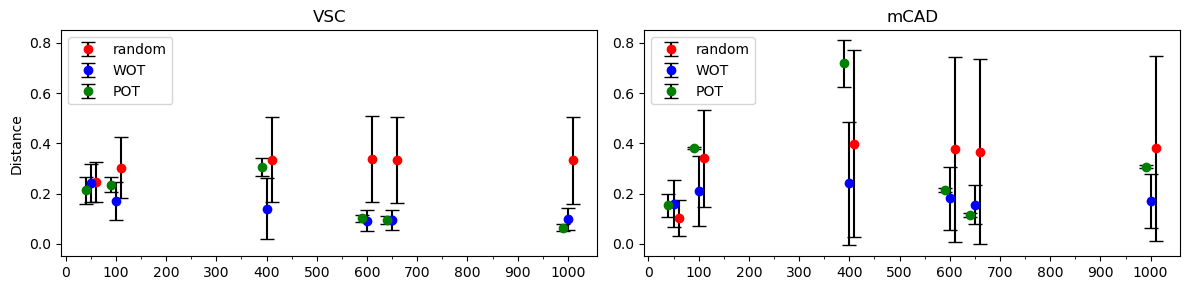

In [11]:
selected_time_points = [0, 50, 100, 400, 600, 650, 1000]

fig, axes = plt.subplots(1, 2, figsize=(12,3))
axes = axes.flatten()
nodes = {
    "VSC": 8,
    "mCAD": 5,
}
for i, net in enumerate(["VSC", "mCAD"]):
    axes[i].errorbar(np.array(selected_time_points[1:])+10, [i[0]/nodes[net] for i in performance[net]["rand"]], [i[1]/nodes[net] for i in performance[net]["rand"]], ecolor="black", fmt="ro", capsize=5, label="random")
    axes[i].errorbar(np.array(selected_time_points[1:]), [i[0]/nodes[net] for i in performance[net]["wot"]], [i[1]/nodes[net] for i in performance[net]["wot"]], ecolor="black", fmt="bo", capsize=5, label="WOT")
    axes[i].errorbar(np.array(selected_time_points[1:])-10, [i[0]/nodes[net] for i in performance[net]["ot"]], [i[1]/nodes[net] for i in performance[net]["ot"]], ecolor="black", fmt="go", capsize=5, label="POT")
    axes[i].set_title(net)
    if i >= 2:
        axes[i].set_xlabel("Time")
    if i % 2 == 0:
        axes[i].set_ylabel("Distance")
    axes[i].legend(loc="upper left")
    axes[i].set_ylim(-0.05, 0.85)
    axes[i].set_xticks(np.arange(0,1001,100))
    axes[i].set_xticks(np.arange(50,1001,100), minor=True)
# fig.suptitle("Normalized trajectory reconstruction errors")
fig.tight_layout()
fig.savefig("plots/trajectory_reconstruction_error.pdf")